# 02 - ANN Baseline Model
## TCI6313 Computational Intelligence Project
### Feedforward Artificial Neural Network for Air Quality Prediction

---

**Objective:** Implement and evaluate a feedforward ANN as the baseline CI model.

**Model Type:** Feedforward Neural Network (Multilayer Perceptron)

**CI Justification:**
- ANNs are fundamental Computational Intelligence models
- Universal function approximators (Cybenko, 1989)
- Learn through gradient-based optimization (backpropagation)
- Serve as baseline for comparison with LSTM and GA-optimized variants

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings

# Add src to path
sys.path.append(os.path.abspath('../src'))

# Import custom modules
from preprocessing import prepare_data_for_ann, inverse_transform_predictions
from ann_model import ANNModel, create_ann_model, train_and_evaluate_ann
from evaluation import (
    evaluate_model, compute_rmse, compute_mae,
    plot_actual_vs_predicted, plot_residuals, plot_training_history,
    print_evaluation_summary, save_results_to_json
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries and modules imported successfully!")

Libraries and modules imported successfully!


## 1. Data Preprocessing

Use our preprocessing module to prepare data for the ANN model.

In [2]:
# Configuration
DATA_PATH = '../data/AirQuality.csv'
TARGET_COLUMN = 'C6H6(GT)'  # Benzene concentration
TEST_SIZE = 0.15
VAL_SIZE = 0.15

# Preprocess data
data = prepare_data_for_ann(
    filepath=DATA_PATH,
    target_column=TARGET_COLUMN,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
    scaler_type='standard',
    random_state=RANDOM_SEED
)

PREPROCESSING PIPELINE FOR ANN
[INFO] Loaded dataset with shape: (9357, 15)
[INFO] Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
[INFO] Created datetime features. New shape: (9357, 23)
[INFO] Missing values before handling: 16701
[INFO] Missing values after handling: 0
[INFO] Final shape after handling missing values: (924, 23)
[INFO] Selected 18 features: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos']
[INFO] Target variable: C6H6(GT)
[INFO] Data split completed:
       Train: 646 samples (69.9%)
       Validation: 139 samples (15.0%)
       Test: 139 samples (15.0%)
[INFO] Data scaled using standard scaler
[INFO] Feature range after scaling - mean: 0.0000, std: 1.0000
PREPROCESSIN

In [3]:
# Extract data
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nFeatures: {data['feature_names']}")

Training samples: 646
Validation samples: 139
Test samples: 139
Number of features: 18

Features: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos']


## 2. ANN Model Architecture

### Design Decisions:
- **Hidden Layers**: 2 layers (64, 32 neurons)
- **Activation**: ReLU (avoids vanishing gradients)
- **Output**: Linear (regression task)
- **Optimizer**: Adam (adaptive learning rate)
- **Regularization**: Dropout (0.2) + L2

In [4]:
# Model Configuration
MODEL_CONFIG = {
    'hidden_layers': [64, 32],
    'learning_rate': 0.001,
    'dropout_rate': 0.2,
    'l2_reg': 0.0001,
    'activation': 'relu'
}

# Training Configuration
TRAIN_CONFIG = {
    'epochs': 100,
    'batch_size': 32,
    'early_stopping_patience': 15
}

print("Model Configuration:")
for k, v in MODEL_CONFIG.items():
    print(f"  {k}: {v}")
print("\nTraining Configuration:")
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")

Model Configuration:
  hidden_layers: [64, 32]
  learning_rate: 0.001
  dropout_rate: 0.2
  l2_reg: 0.0001
  activation: relu

Training Configuration:
  epochs: 100
  batch_size: 32
  early_stopping_patience: 15


In [5]:
# Create ANN Model
ann_model = ANNModel(
    n_features=data['n_features'],
    hidden_layers=MODEL_CONFIG['hidden_layers'],
    learning_rate=MODEL_CONFIG['learning_rate'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    l2_reg=MODEL_CONFIG['l2_reg'],
    activation=MODEL_CONFIG['activation'],
    random_seed=RANDOM_SEED
)

# Build the model
ann_model.build()

[INFO] Building ANN model...

MODEL ARCHITECTURE


Model: "ANN_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 192 (768.00 B)

## 3. Model Training

Train the ANN with early stopping to prevent overfitting.

In [6]:
# Train the model
history = ann_model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=TRAIN_CONFIG['epochs'],
    batch_size=TRAIN_CONFIG['batch_size'],
    early_stopping_patience=TRAIN_CONFIG['early_stopping_patience'],
    verbose=1
)

[INFO] Starting training...
       Epochs: 100, Batch size: 32
       Training samples: 646
       Validation samples: 139
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.2534 - mae: 1.1585 - val_loss: 1.2889 - val_mae: 0.8683 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1188 - mae: 0.8086 - val_loss: 0.6126 - val_mae: 0.6098 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8415 - mae: 0.7161 - val_loss: 0.3797 - val_mae: 0.4886 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7382 - mae: 0.6741 - val_loss: 0.3518 - val_mae: 0.4688 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6459 - mae: 0.6298 - val_loss: 0.2771 - val_mae: 0.4094 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5856 - mae: 0.5954 - val_loss: 0.1577 - val_mae: 0.3035 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━

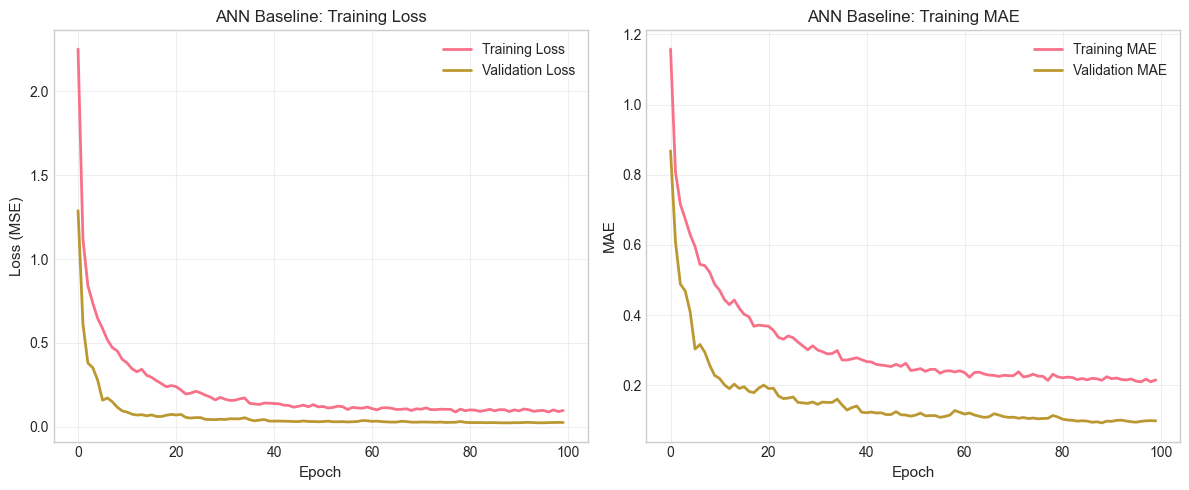

In [7]:
# Plot training history
fig = plot_training_history(history, model_name='ANN Baseline')
plt.show()

## 4. Model Evaluation

In [ ]:
# Make predictions
y_pred_train = ann_model.predict(X_train)
y_pred_val = ann_model.predict(X_val)
y_pred_test = ann_model.predict(X_test)

# Inverse transform to original scale
y_train_orig = inverse_transform_predictions(y_train, data['target_scaler'])
y_val_orig = inverse_transform_predictions(y_val, data['target_scaler'])
y_test_orig = inverse_transform_predictions(y_test, data['target_scaler'])

y_pred_train_orig = inverse_transform_predictions(y_pred_train, data['target_scaler'])
y_pred_val_orig = inverse_transform_predictions(y_pred_val, data['target_scaler'])
y_pred_test_orig = inverse_transform_predictions(y_pred_test, data['target_scaler'])

In [9]:
# Evaluate on all sets
print("="*60)
print("ANN BASELINE EVALUATION RESULTS")
print("="*60)

# Training set
train_metrics = evaluate_model(y_train_orig, y_pred_train_orig, 'ANN-Train')
print(f"\nTraining Set:")
print(f"  RMSE: {train_metrics['rmse']:.4f}")
print(f"  MAE:  {train_metrics['mae']:.4f}")
print(f"  R²:   {train_metrics['r2']:.4f}")

# Validation set
val_metrics = evaluate_model(y_val_orig, y_pred_val_orig, 'ANN-Val')
print(f"\nValidation Set:")
print(f"  RMSE: {val_metrics['rmse']:.4f}")
print(f"  MAE:  {val_metrics['mae']:.4f}")
print(f"  R²:   {val_metrics['r2']:.4f}")

# Test set
test_metrics = evaluate_model(y_test_orig, y_pred_test_orig, 'ANN-Test', 
                               training_time=ann_model.training_time)
print(f"\nTest Set:")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE:  {test_metrics['mae']:.4f}")
print(f"  R²:   {test_metrics['r2']:.4f}")

print(f"\nTraining Time: {ann_model.training_time:.2f} seconds")
print("="*60)

ANN BASELINE EVALUATION RESULTS

Training Set:
  RMSE: 0.5902
  MAE:  0.4441
  R²:   0.9929

Validation Set:
  RMSE: 0.8630
  MAE:  0.6491
  R²:   0.9880

Test Set:
  RMSE: 0.8024
  MAE:  0.5914
  R²:   0.9900

Training Time: 27.51 seconds


## 5. Visualizations

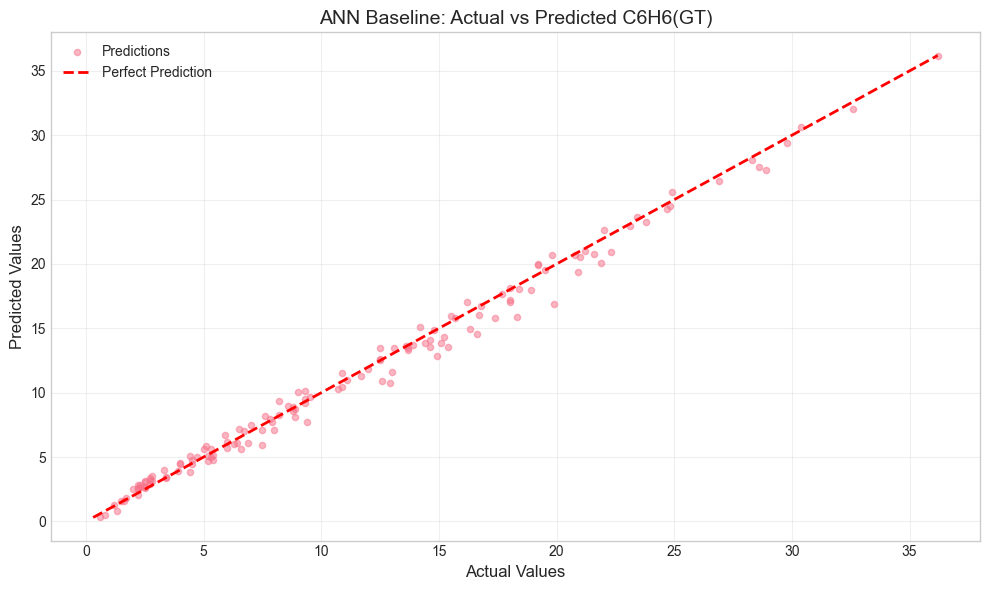

In [10]:
# Actual vs Predicted plot
fig = plot_actual_vs_predicted(
    y_test_orig, y_pred_test_orig,
    model_name='ANN Baseline',
    title=f'ANN Baseline: Actual vs Predicted {TARGET_COLUMN}'
)
plt.show()

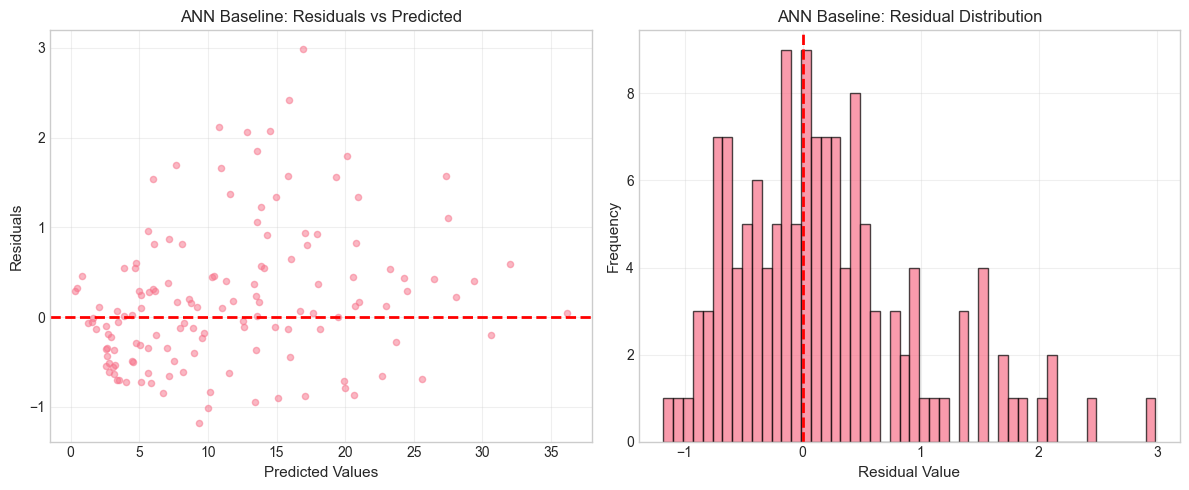

In [11]:
# Residual analysis
fig = plot_residuals(y_test_orig, y_pred_test_orig, model_name='ANN Baseline')
plt.show()

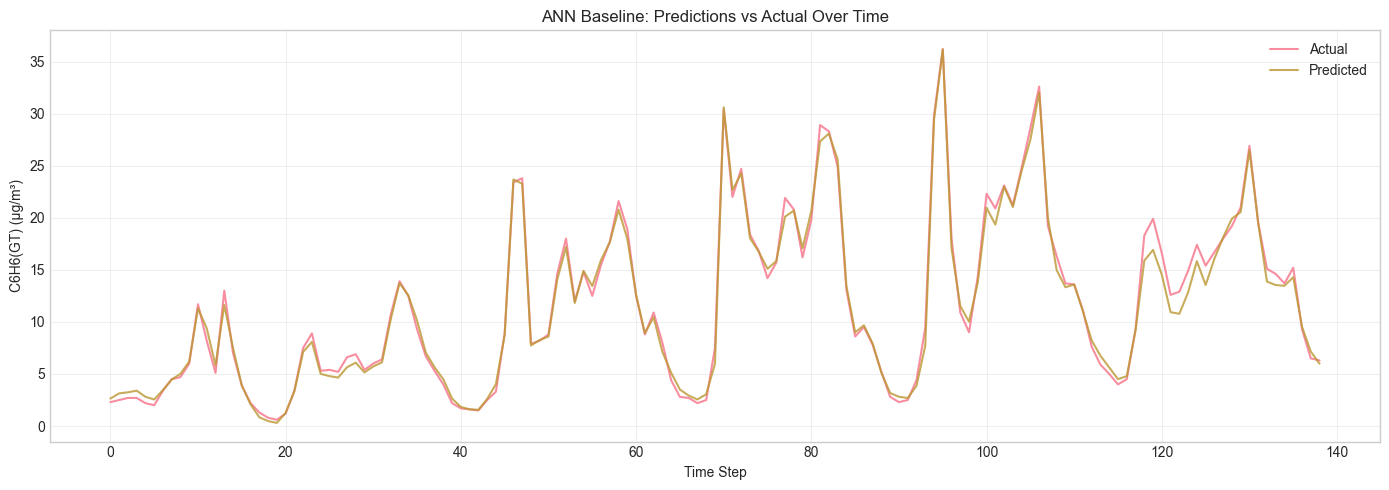

In [13]:
# Predictions over time (last 200 points or all available)
n_points = min(200, len(y_test_orig))

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(range(n_points), y_test_orig[-n_points:], label='Actual', alpha=0.8, lw=1.5)
ax.plot(range(n_points), y_pred_test_orig[-n_points:], label='Predicted', alpha=0.8, lw=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel(f'{TARGET_COLUMN} (µg/m³)')
ax.set_title('ANN Baseline: Predictions vs Actual Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Save Results

In [14]:
# Compile results
ann_results = {
    'model_type': 'ANN',
    'model_config': MODEL_CONFIG,
    'train_config': TRAIN_CONFIG,
    'metrics': {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    },
    'training_time': ann_model.training_time,
    'history': history,
    'predictions': {
        'test_actual': y_test_orig.tolist(),
        'test_predicted': y_pred_test_orig.tolist()
    }
}

# Save to JSON
save_results_to_json(ann_results, '../results/ann_baseline_results.json')

print("Results saved successfully!")

[INFO] Results saved to ../results/ann_baseline_results.json
Results saved successfully!
